# Theory
What are the main effects, interactions, higher order effects, confounding variables etc...?

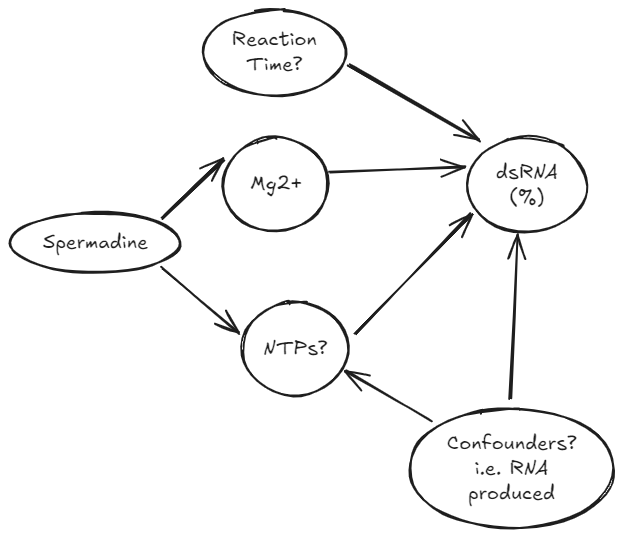
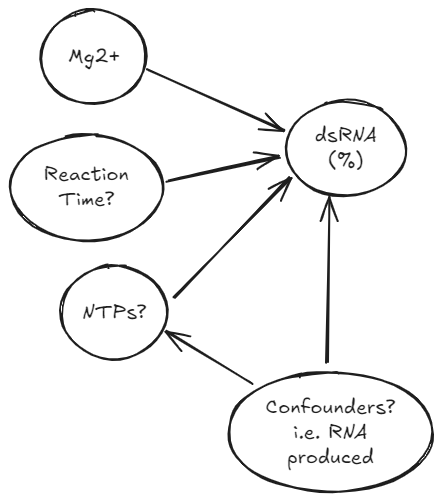

In [1]:
import r3.adapters as adapters
import r3.schema as schema

X_columns = [
    schema.IVTReactionSchema.NTP_M.value,
    schema.IVTReactionSchema.T7RNAP_u_uL.value,
    schema.IVTReactionSchema.DNA_ug_mL.value,
    schema.IVTReactionSchema.Mg2_M.value,
    schema.IVTReactionSchema.TIME_min.value,
]
y_columns = [schema.IVTReactionSchema.dsRNA_percent.value]

experimental_conditions, responses = adapters.DataPipelineAdapter("dsrna_lhs").get(
    X_columns=X_columns,
    y_columns=y_columns,
)

experimental_conditions

📊 Extracted DataFrame with columns ['NTPs [M]', 'T7RNAP [units/uL]', 'DNA [µg/mL]', 'Mg2+ [M]', 'Reaction Time [min]'] and ['dsRNA [%]']
X shape: (80, 5), y shape: (80, 1)
X head:
   NTPs [M]  T7RNAP [units/uL]  DNA [µg/mL]  Mg2+ [M]  Reaction Time [min]
0  0.002237         109.285882    49.217245  0.013340            15.975448
1  0.011370         102.000948    92.963862  0.045625           205.895482
2  0.013120         301.864929    91.286401  0.034906            89.767563
3  0.012105         277.820595    61.743404  0.026270            44.601100
4  0.012105         277.820595    61.743404  0.026270            44.601100
y head:
   dsRNA [%]
0   2.130682
1   0.411220
2   0.035209
3   0.422909
4   0.150595


,NTPs [M],T7RNAP [units/uL],DNA [µg/mL],Mg2+ [M],Reaction Time [min]
0,0.002237,109.285882,49.217245,0.013340,15.975448
1,0.011370,102.000948,92.963862,0.045625,205.895482
2,0.013120,301.864929,91.286401,0.034906,89.767563
3,0.012105,277.820595,61.743404,0.026270,44.601100
4,0.012105,277.820595,61.743404,0.026270,44.601100
...,...,...,...,...,...
75,0.014942,359.010522,54.952946,0.054598,143.752553
76,0.002423,148.507894,81.381476,0.009032,188.421396
77,0.008220,337.662327,74.517838,0.028639,73.872966
78,0.011866,287.674023,69.082018,0.067321,92.660776


## Feature Generation
- symbolic regression
- polynomial regression
- expert knowledge

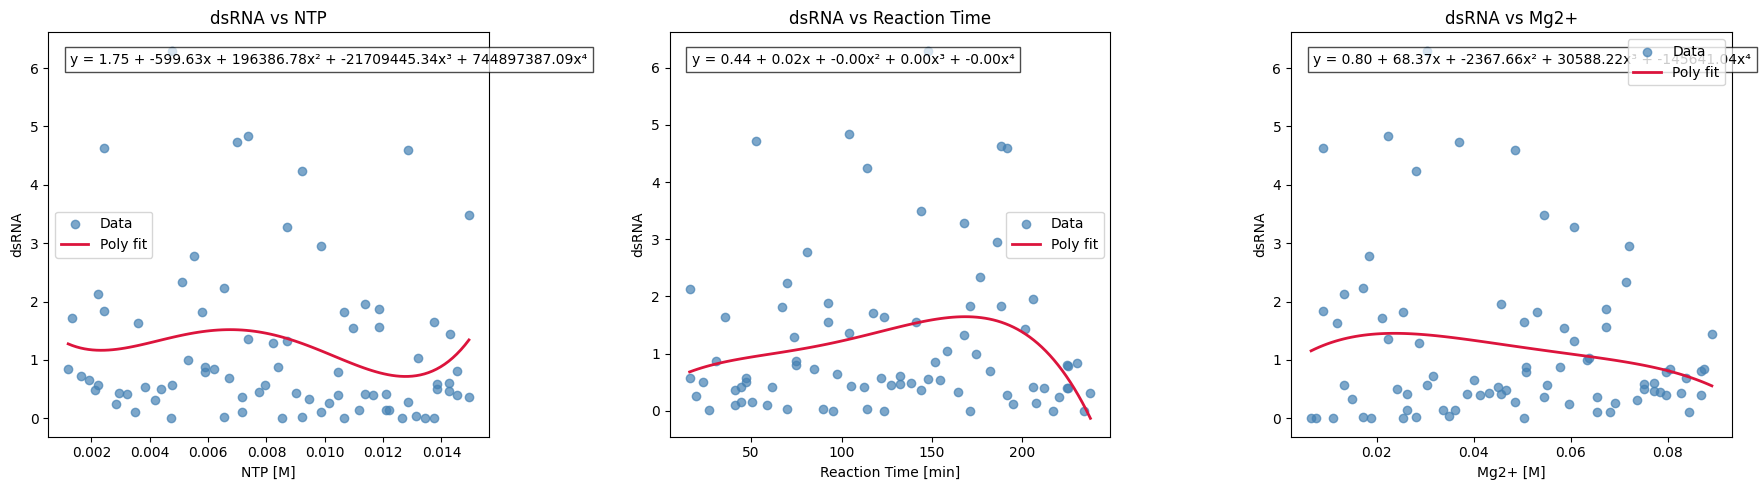

In [29]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import numpy as np

import matplotlib.pyplot as plt

# Prepare data
X_ntp = anova_data["NTP_M"].values.reshape(-1, 1)
X_time = anova_data["TIME_min"].values.reshape(-1, 1)
X_mg = anova_data["Mg2_M"].values.reshape(-1, 1)
y_dsrna = anova_data["dsRNA"].values


poly = PolynomialFeatures(degree=4)
models = []
X_list = [X_ntp, X_time, X_mg]
titles = ["dsRNA vs NTP", "dsRNA vs Reaction Time", "dsRNA vs Mg2+"]
xlabels = ["NTP [M]", "Reaction Time [min]", "Mg2+ [M]"]

for X in X_list:
    X_poly = poly.fit_transform(X)
    model = LinearRegression().fit(X_poly, y_dsrna)
    models.append(model)

# Plot results in a grid
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, X, model, title, xlabel in zip(axes, X_list, models, titles, xlabels):
    # Scatter plot
    ax.scatter(X, y_dsrna, color="steelblue", alpha=0.7, label="Data")
    # Prediction curve
    x_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    x_range_poly = poly.transform(x_range)
    y_pred = model.predict(x_range_poly)
    ax.plot(x_range, y_pred, color="crimson", lw=2, label="Poly fit")
    # Equation (full 4th order polynomial)
    coefs = model.coef_
    intercept = model.intercept_
    eq = (
        f"y = {intercept:.2f}"
        f" + {coefs[1]:.2f}x"
        f" + {coefs[2]:.2f}x²"
        f" + {coefs[3]:.2f}x³"
        f" + {coefs[4]:.2f}x⁴"
    )
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("dsRNA")
    ax.legend()
    ax.text(
        0.05,
        0.95,
        eq,
        transform=ax.transAxes,
        fontsize=10,
        verticalalignment="top",
        bbox=dict(facecolor="white", alpha=0.7),
    )

plt.tight_layout()
plt.show()

dsRNA vs NTP:
  y = 1.7491 + -599.6342x^1 + 196386.7776x^2 + -21709445.3436x^3 + 744897387.0865x^4
  R² = 0.038

dsRNA vs Reaction Time:
  y = 0.4376 + 0.0193x^1 + -0.0003x^2 + 0.0000x^3 + -0.0000x^4
  R² = 0.082

dsRNA vs Mg2+:
  y = 0.8043 + 68.3655x^1 + -2367.6590x^2 + 30588.2176x^3 + -145641.0422x^4
  R² = 0.034



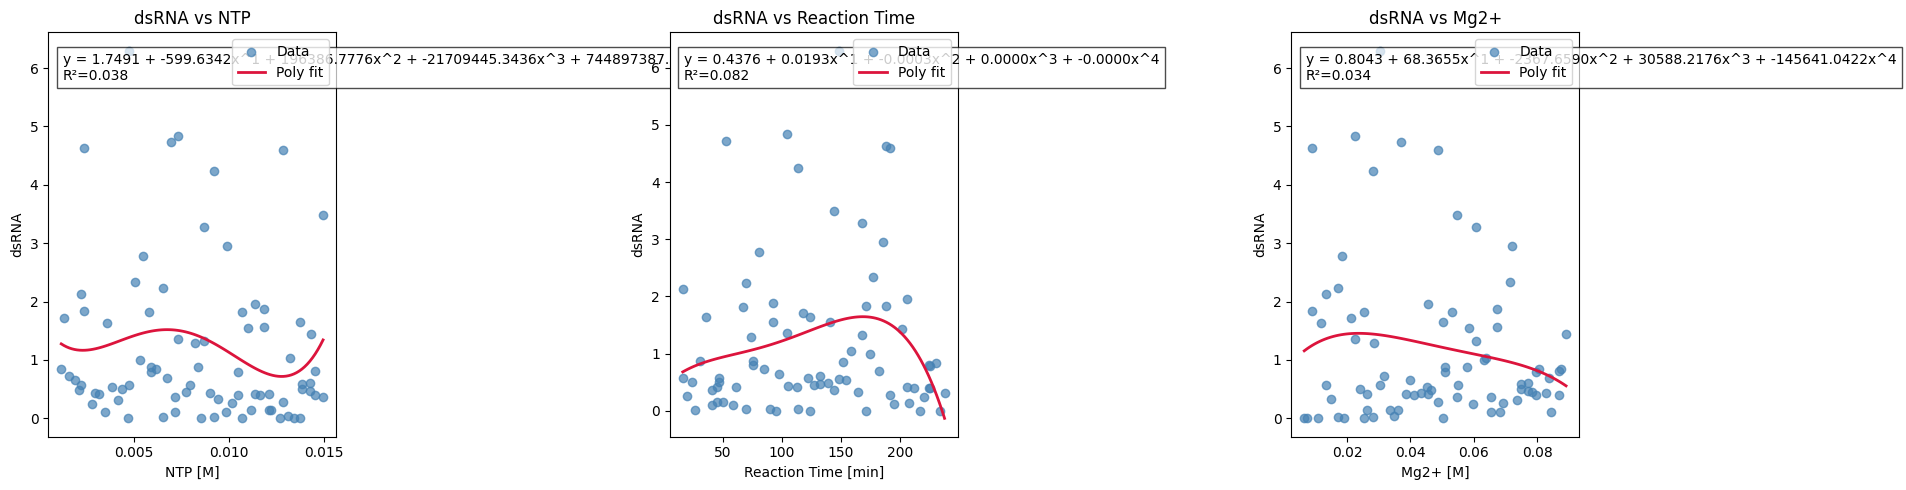

In [30]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import numpy as np

import matplotlib.pyplot as plt

# Prepare data
X_ntp = anova_data["NTP_M"].values.reshape(-1, 1)
X_time = anova_data["TIME_min"].values.reshape(-1, 1)
X_mg = anova_data["Mg2_M"].values.reshape(-1, 1)
y_dsrna = anova_data["dsRNA"].values

poly = PolynomialFeatures(degree=4)
models = []
scores = []
equations = []
X_list = [X_ntp, X_time, X_mg]
titles = ["dsRNA vs NTP", "dsRNA vs Reaction Time", "dsRNA vs Mg2+"]
xlabels = ["NTP [M]", "Reaction Time [min]", "Mg2+ [M]"]

for X in X_list:
    X_poly = poly.fit_transform(X)
    model = LinearRegression().fit(X_poly, y_dsrna)
    models.append(model)
    score = model.score(X_poly, y_dsrna)
    scores.append(score)
    coefs = model.coef_
    intercept = model.intercept_
    eq = f"y = {intercept:.4f}"
    for deg in range(1, 5):
        eq += f" + {coefs[deg]:.4f}x^{deg}"
    equations.append(eq)

# Print polynomial equations and fit accuracy
for title, eq, score in zip(titles, equations, scores):
    print(f"{title}:\n  {eq}\n  R² = {score:.3f}\n")

# Plot results in a grid
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, X, model, title, xlabel, eq, score in zip(
    axes, X_list, models, titles, xlabels, equations, scores
):
    # Scatter plot
    ax.scatter(X, y_dsrna, color="steelblue", alpha=0.7, label="Data")
    # Prediction curve
    x_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    x_range_poly = poly.transform(x_range)
    y_pred = model.predict(x_range_poly)
    ax.plot(x_range, y_pred, color="crimson", lw=2, label="Poly fit")
    # Equation and R²
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("dsRNA")
    ax.legend()
    ax.text(
        0.05,
        0.95,
        f"{eq}\nR²={score:.3f}",
        transform=ax.transAxes,
        fontsize=10,
        verticalalignment="top",
        bbox=dict(facecolor="white", alpha=0.7),
    )

plt.tight_layout()
plt.show()

## Feature Selection


In [2]:
import plotly.graph_objects as go
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import pandas as pd

# Use descriptive variable names
anova_data = pd.DataFrame(
    data={
        "dsRNA": responses.values.ravel(),
        "NTP_M": experimental_conditions[X_columns[0]].values.ravel(),
        "T7RNAP_u_uL": experimental_conditions[X_columns[1]].values.ravel(),
        "DNA_ug_mL": experimental_conditions[X_columns[2]].values.ravel(),
        "Mg2_M": experimental_conditions[X_columns[3]].values.ravel(),
        "TIME_min": experimental_conditions[X_columns[4]].values.ravel(),
    }
)

# Build formula with all main effects and all interaction effects (up to 5-way)
formula = "dsRNA ~ NTP_M + T7RNAP_u_uL + DNA_ug_mL + Mg2_M + TIME_min + NTP_M * Mg2_M + T7RNAP_u_uL * NTP_M + T7RNAP_u_uL * DNA_ug_mL + T7RNAP_u_uL * Mg2_M + T7RNAP_u_uL * TIME_min + DNA_ug_mL * Mg2_M + DNA_ug_mL * TIME_min + Mg2_M * TIME_min + NTP_M * T7RNAP_u_uL * DNA_ug_mL + NTP_M * T7RNAP_u_uL * Mg2_M + NTP_M * T7RNAP_u_uL * TIME_min + NTP_M * DNA_ug_mL * Mg2_M + NTP_M * DNA_ug_mL * TIME_min + NTP_M * Mg2_M * TIME_min + T7RNAP_u_uL * DNA_ug_mL * Mg2_M + T7RNAP_u_uL * DNA_ug_mL * TIME_min + T7RNAP_u_uL * Mg2_M * TIME_min + DNA_ug_mL * Mg2_M * TIME_min"

lm = ols(formula=formula, data=anova_data).fit()

# Show full model summary
print(lm.summary())

# ANOVA table
anova_results = anova_lm(lm)
print("\nANOVA Table:")
print(anova_results)

# Extract p-values and F-statistics
anova_results = anova_results.reset_index().rename(columns={"index": "Term"})
anova_results["Significant"] = anova_results["PR(>F)"] < 0.05

# Plot p-values for all terms
fig = go.Figure(
    data=[
        go.Bar(
            y=anova_results["Term"],
            x=anova_results["PR(>F)"],
            orientation="h",
            marker_color=[
                "crimson" if sig else "steelblue"
                for sig in anova_results["Significant"]
            ],
            text=[
                f"F={fval:.2f}, p={pval:.3g}"
                for fval, pval in zip(anova_results["F"], anova_results["PR(>F)"])
            ],
            hoverinfo="text",
        )
    ]
)

fig.add_vline(
    x=0.05,
    line_width=3,
    line_dash="dash",
    line_color="red",
    annotation_text="p=0.05",
    annotation_position="top right",
)
fig.update_xaxes(title="p-value", range=[0, 1])
fig.update_yaxes(title="Model Term")
fig.update_layout(
    barmode="stack",
    title_text="ANOVA Model Term p-values (red = significant, p < 0.05)",
    yaxis={"categoryorder": "total ascending"},
    height=800,
)

                            OLS Regression Results                            
Dep. Variable:                  dsRNA   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                 -0.152
Method:                 Least Squares   F-statistic:                    0.5830
Date:                Fri, 03 Oct 2025   Prob (F-statistic):              0.929
Time:                        08:40:05   Log-Likelihood:                -127.07
No. Observations:                  80   AIC:                             306.1
Df Residuals:                      54   BIC:                             368.1
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [3]:
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

# Prepare X and y
X = experimental_conditions.values
y = responses.values.ravel()

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit XGBoost regressor
xgb = XGBRegressor(random_state=42)
xgb.fit(X_scaled, y)

# Predict and score
y_pred = xgb.predict(X_scaled)
score = r2_score(y, y_pred)
print(f"XGBoost R^2 score on training set: {score:.3f}")

XGBoost R^2 score on training set: 0.583


In [4]:
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score

# Use XGBRegressor for RFE
estimator = XGBRegressor(random_state=42)

# Perform RFE, dropping 1 feature at each iteration
rfe = RFE(estimator, n_features_to_select=1, step=1)
rfe.fit(X_scaled, y)

# Get ranking and feature names
ranking = rfe.ranking_
features_ranked = [X_columns[i] for i in ranking.argsort()]

print("Feature ranking (best to worst):")
for i, feat in enumerate(features_ranked):
    print(f"{i+1}. {feat}")

# R2 for best feature
best_idx = ranking.argsort()[0]
X_best = X_scaled[:, best_idx].reshape(-1, 1)
estimator.fit(X_best, y)
y_pred_best = estimator.predict(X_best)
r2_best = r2_score(y, y_pred_best)
print(f"\nR² score using only the best feature ({features_ranked[0]}): {r2_best:.3f}")

Feature ranking (best to worst):
1. Reaction Time [min]
2. Mg2+ [M]
3. DNA [µg/mL]
4. NTPs [M]
5. T7RNAP [units/uL]

R² score using only the best feature (Reaction Time [min]): 0.583


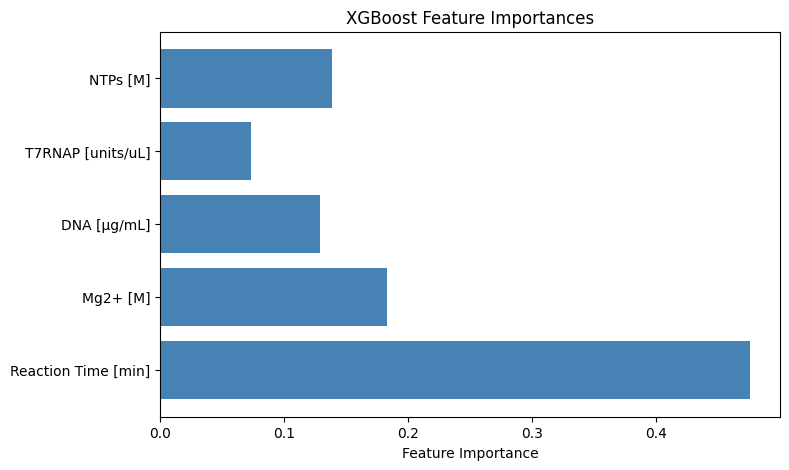

In [5]:
import matplotlib.pyplot as plt

# Get feature importances from the trained XGBoost model
importances = xgb.feature_importances_
feature_names = X_columns

# Plot horizontal bar chart
plt.figure(figsize=(8, 5))
plt.barh(feature_names, importances, color="steelblue")
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importances")
plt.gca().invert_yaxis()
plt.show()

XGBoost R^2 score with noise: 1.000


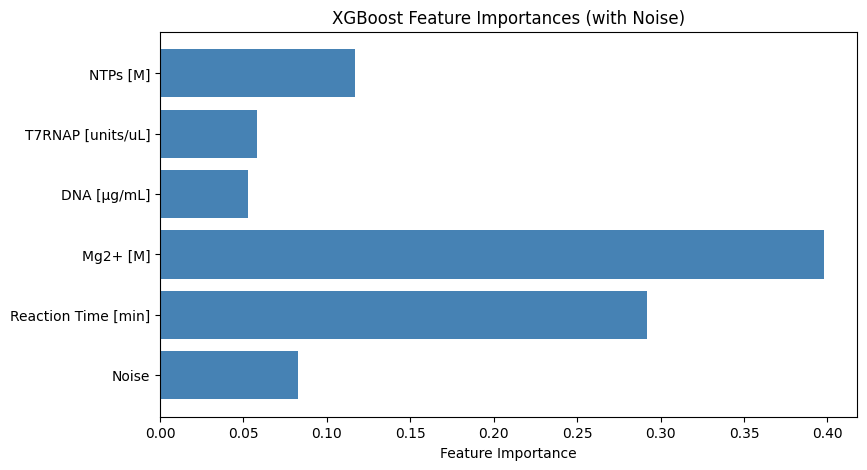

In [6]:
import numpy as np

import matplotlib.pyplot as plt

# Add a noise column to X_scaled
np.random.seed(42)
noise = np.random.normal(0, 1, size=(X_scaled.shape[0], 1))
X_scaled_noise = np.hstack([X_scaled, noise])
feature_names_noise = X_columns + ["Noise"]

# Fit XGBoost regressor with noise
xgb_noise = XGBRegressor(random_state=42)
xgb_noise.fit(X_scaled_noise, y)

# Predict and score
y_pred_noise = xgb_noise.predict(X_scaled_noise)
score_noise = r2_score(y, y_pred_noise)
print(f"XGBoost R^2 score with noise: {score_noise:.3f}")

# Feature importances
importances_noise = xgb_noise.feature_importances_

# Plot horizontal bar chart
plt.figure(figsize=(9, 5))
plt.barh(feature_names_noise, importances_noise, color="steelblue")
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importances (with Noise)")
plt.gca().invert_yaxis()
plt.show()

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Split data into train and test sets (e.g., 80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_noise, y, test_size=0.2, random_state=42
)

# Fit XGBoost regressor on training set
xgb_noise_split = XGBRegressor(random_state=42, n_estimators=8)
xgb_noise_split.fit(X_train, y_train)

# Predict on test set
y_pred_test = xgb_noise_split.predict(X_test)

# Evaluate R^2 score on test set
score_test = r2_score(y_test, y_pred_test)
print(f"XGBoost R^2 score on test set (with noise): {score_test:.3f}")

# Evaluate R^2 score on training set
y_pred_train = xgb_noise_split.predict(X_train)
score_train = r2_score(y_train, y_pred_train)
print(f"XGBoost R^2 score on training set (with noise): {score_train:.3f}")

XGBoost R^2 score on test set (with noise): -0.128
XGBoost R^2 score on training set (with noise): 0.936
